In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# custom functions
from functions import *

2024-11-18 23:03:31.014640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731967411.033329   34722 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731967411.038797   34722 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 23:03:31.056536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('../data/clean/dataset.csv').fillna('').sample(frac=1, random_state=314).reset_index(drop=True)

In [3]:
df

,name,url,title,lemmes,funny
0,la_depeche,https://www.ladepeche.fr/2024/09/29/145-person...,145 personnes ont donné leur sang en trois jours,personne donner sang jour,0
1,le_parisien,https://www.leparisien.fr/essonne-91/juvisy-su...,Juvisy-sur-Orge : il crache sur des policiers ...,juvisy-sur-orge cracher policier annoncer sero...,0
2,le_parisien,https://www.leparisien.fr/faits-divers/8-avril...,8 avril 1979 : le « tueur de l’Oise » arrêté...,avril tueur oise arrete assassin eter gendarme,0
3,la_depeche,https://www.ladepeche.fr/2024/10/09/grande-soi...,"Grande soirée théâtre, samedi 19",grand soiree theatre samedi,0
4,franceinfotv,https://www.francetvinfo.fr/les-jeux-olympique...,"Paris 2024 : près de 10 000 défilants, accès g...",paris defilant acces gratuit best of musical f...,0
...,...,...,...,...,...
106557,la_depeche,https://www.ladepeche.fr/2024/10/16/randonnee-...,Randonnée de la pleine lune,randonnee plein lune,0
106558,rfi,https://www.rfi.fr/fr/podcasts/la-marche-du-mo...,Tchad : quand les femmes prennent la voix du s...,tchad femme prendre voix syndicat,0
106559,rfi,https://www.rfi.fr/fr/podcasts/le-journal-d-ou...,Journal d'Outre-mer du 20 septembre 2024,journal outre-mer septembre,0
106560,le_parisien,https://www.leparisien.fr/val-de-marne-94/val-...,Val-de-Marne : le pont de Sucy-en-Brie rouvre ...,val-de-marne pont sucy-en-brie rouvrir circula...,0


In [4]:
embeddings = word2vec_embed(df['lemmes'].to_list())

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (48412, 300)


/home/michael/.pyenv/versions/funnypress-data-study/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1731967571.684810   34722 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1730 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 24, 300)        │    14,523,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,523,600 (55.40 MB)

 Trainable params: 14,523,600 (55.40 MB)

 Non-trainable params: 0 (0.00 B)

  38/3331 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step    

/home/michael/.pyenv/versions/funnypress-data-study/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1731967572.582346   36427 service.cc:148] XLA service 0x7f6ff0003f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731967572.582370   36427 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
I0000 00:00:1731967572.590501   36427 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-18 23:06:12.605717: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or 

3331/3331 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
(106562, 300)


<Figure size 800x600 with 0 Axes>

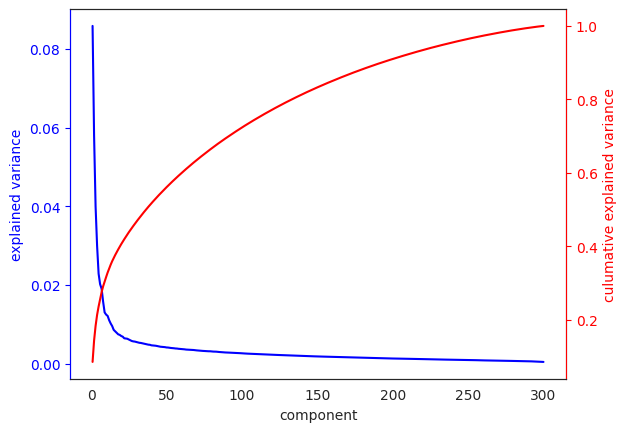

In [5]:
pca_graph(embeddings)

In [6]:
y = df.funny

In [7]:
umap_embedding = umap.UMAP(n_components=2, n_jobs=-1, verbose=1, random_state=314).fit_transform(embeddings)    

/home/michael/.pyenv/versions/funnypress-data-study/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=314, verbose=1)
Mon Nov 18 23:06:19 2024 Construct fuzzy simplicial set
Mon Nov 18 23:06:19 2024 Finding Nearest Neighbors
Mon Nov 18 23:06:19 2024 Building RP forest with 21 trees
Mon Nov 18 23:06:33 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	Stopping threshold met -- exiting after 6 iterations
Mon Nov 18 23:07:00 2024 Finished Nearest Neighbor Search
Mon Nov 18 23:07:05 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Nov 18 23:08:58 2024 Finished embedding


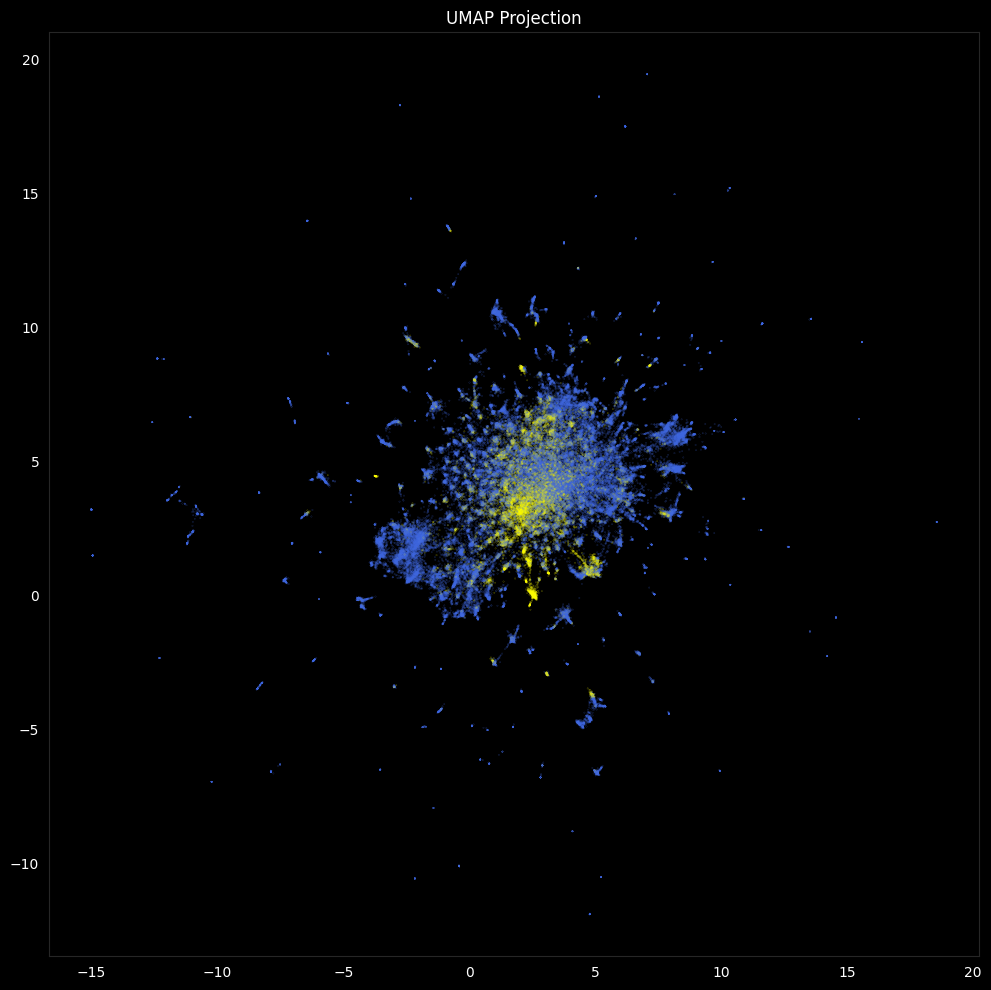

In [8]:
umap_graph(umap_embedding, y)